# This notebook contains the code for Task 2 for the CMEG Dataset

# Project Setup

## Installing required libs and importing them

In [ ]:
!pip install lightgbm
!pip install coral_pytorch
!pip install catboost
!pip install pytorch-tabnet
!pip install deslib
!pip install hyperopt
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl
!apt install libomp-dev
!pip install faiss
!pip install pytorch_tabular[all]

     |████████████████████████████████| 76.1 MB 2.0 MB/s 
     |████████████████████████████████| 158 kB 7.5 MB/s 
--2022-03-25 12:42:31--  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9c5c376961204909d87/5aa7f0a65571b411e5c259be?response-content-disposition=attachment%3B%20filename%3D%22faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20220325T124232Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEOj%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIQCTyP3D

Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean
from numpy import std
from numpy import arange
from numpy import save

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from scipy.stats import kendalltau
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression

import faiss

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import pickle

from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.des.des_mi import DESMI
from deslib.static import StackedClassifier

from imblearn.over_sampling import SMOTE,BorderlineSMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm

from sklearn.neighbors import LocalOutlierFactor

## Loading Data - (Has been imputed already - CMeg Dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cmeg_df = pd.read_excel(r'/content/drive/MyDrive/AI Case Study Data/cmeg_df_case_competition_scrambled_train.xlsx', sheet_name='Data')

# Data Preparation

Following tasks have been completed here:

1.   Feature Engineering
2.   Train Test Split
3.   Scaling features
4.   Imputing missing values
5.   Removing outliers
6.   Oversampling to balance classes



### Define functions for creating of new features ( Each function has a comment for its explaination)

In [ ]:
cmeg_df = cmeg_df.sort_values(by = ['ROW'], ascending=False)

non_fin_features = ['ROW', 'Corp_Residence_Country_Code', 'BR Code', 'Period', 'CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG']
fin_features = np.sort(list(set(cmeg_df.columns) - set(non_fin_features)))

# 3 year averages function for each metric
def three_year_average(X, col_y0, col_y1, col_y2, col):
    X.drop(X[X[col_y0].isnull()].index, inplace = True)
    
    X[col] = X[col_y0]
    
    two_years_average = X[col_y1].notnull() & X[col_y2].isnull()
    X.loc[two_years_average, col] = X.loc[two_years_average, col_y0] * 4/7 + X.loc[two_years_average, col_y1] * 3/7
    
    three_years_average = X[col_y1].notnull() & X[col_y2].notnull()
    X.loc[three_years_average, col] = X.loc[three_years_average, col_y0] * 4/9 + X.loc[three_years_average, col_y1] * 3/9 + X.loc[three_years_average, col_y2] * 2/9
    
    return X

cols_to_avg = []

for col in fin_features:
    if (col.endswith('Y0') and not col.endswith('growth_Y0')):
        cols_to_avg.append([col, col[:-2] + 'Y1', col[:-2] + 'Y2', col[:-2] + '3YearAverage'])

data_left = cmeg_df.copy()
for col0, col1, col2, col in cols_to_avg:
    orig_num_data = len(data_left)
    data_left = three_year_average(data_left, col0, col1, col2, col)
    remaining_data = len(data_left)
    # print((orig_num_data - remaining_data), 'data records are dropped due to ' + col + '\n')

data_left = data_left.reset_index(drop = True)

for i in range(4):
    data_left['DEBT2EBITDA_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['EBITDA_Y' + str(i)]
    data_left['DEBT2CAPT_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['CAPITALIZATION_Y' + str(i)]
    data_left['DEBT2EQUITY_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALEQUITY_Y' + str(i)]
    data_left['DEBT2ASSET_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['DEBT2TANGIBLENW_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['tangibleNetWorth_Y' + str(i)]
    data_left['CASH2ASSET_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['CASH2DEBT_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALDEBT_Y' + str(i)]
    data_left['CA2CL_Y'+str(i)] = data_left['CURRENTASSET_Y'+str(i)] / data_left['CURRENTLIABILITY_Y' + str(i)]

    # Quick (acid-test) ratio = (cash + short term investments + net current recievables ) / current liabilities
    # CCE = cash + short term investments, ARTurnover ~ net current recievables
    data_left['ACIDTESTRATIO_Y'+str(i)] = (data_left['CCE_Y'+str(i)] + data_left['ARTurnover_Y'+str(i)])/ data_left['CURRENTLIABILITY_Y' + str(i)]

    # Inventory Turnover = 365/ inventory days
    data_left['INVENTORYTURNOVER_Y'+str(i)] = 365 / data_left['INVENTORYDAYS_Y' + str(i)]
    # Cost of Goods Sold = Inventory Turnover * Average Inventory
    data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['Inventory_Y' + str(i)]
    
    # Cash Conversion Cycle = Inventory Days + Recievable Days - Payable Days
    data_left['CCC_Y'+str(i)] = data_left['INVENTORYDAYS_Y' + str(i)] + data_left['receivabledays_Y' + str(i)] - data_left['payableDAYS_Y' + str(i)]

    # Times Intrest Earned Ratio = operating income/ intrest expense
    # operating profit = operating income - operating expenses (do not have op expenses)
    data_left['TIERATIO_Y'+str(i)] = data_left['OPERPROFIT_Y'+str(i)] / data_left['TOTINTEXP_Y' + str(i)]

    # Return on Assets Ratio = net income / average total assets
    # net income = net profit
    data_left['ROARATIO_Y'+str(i)] = data_left['NETPROFIT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]

    # Enterprise Value = debt + equity - cash
    data_left['EnterpriseValue_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] + data_left['TOTALEQUITY_Y' + str(i)] - data_left['CCE_Y' + str(i)]


for i in range(3):
    data_left['DEBT2FCF_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] / data_left['FCF_Y'+str(i)]\

# add bins for total assets 
data_left['TotalAssetBINS'] = pd.qcut(data_left['TOTALASSET_3YearAverage'], 4, labels=[1,2,3,4]).astype(int)

# calculate average year over year growth
relevant_feat = ['TOTALREVENUE_Y', 'CAPITALIZATION_Y', 'TOTALDEBT_Y', 'TOTALASSET_Y', 'NETSALES_Y']
for feat in relevant_feat:
  data_left[feat+'OYGrowth'] = 0

  maskY2 = data_left[feat+str(2)].isnull() & data_left[feat+str(1)].notnull()
  data_left.loc[maskY2, feat+'OYGrowth'] += (data_left.loc[maskY2, feat+str(0)] - data_left.loc[maskY2, feat+str(1)])/data_left.loc[maskY2, feat+str(1)]

  maskY3 = data_left[feat+str(3)].isnull() & data_left[feat+str(2)].notnull()
  data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(0)] - data_left.loc[maskY3, feat+str(1)])/data_left.loc[maskY3, feat+str(1)]
  data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(1)] - data_left.loc[maskY3, feat+str(2)])/data_left.loc[maskY3, feat+str(2)]
  data_left.loc[maskY3, feat+'OYGrowth'] = data_left.loc[maskY3, feat+'OYGrowth']/2

  maskAllY = data_left[feat+str(3)].notnull()
  data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(0)] - data_left.loc[maskAllY, feat+str(1)])/data_left.loc[maskAllY, feat+str(1)]
  data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(1)] - data_left.loc[maskAllY, feat+str(2)])/data_left.loc[maskAllY, feat+str(2)]
  data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(2)] - data_left.loc[maskAllY, feat+str(3)])/data_left.loc[maskAllY, feat+str(3)]
  data_left.loc[maskAllY, feat+'OYGrowth'] = data_left.loc[maskAllY, feat+'OYGrowth']/3

data_left[['TOTALREVENUE_YOYGrowth', 'TOTALREVENUE_Y0', 'TOTALREVENUE_Y1', 'TOTALREVENUE_Y2', 'TOTALREVENUE_Y3' ]]

new_feat = ['DEBT2EBITDA_Y','DEBT2CAPT_Y', 'DEBT2EQUITY_Y', 'DEBT2ASSET_Y', 'DEBT2TANGIBLENW_Y', 'CASH2ASSET_Y', 'CASH2DEBT_Y', 'CA2CL_Y']
new_feat2 = ['ACIDTESTRATIO_Y', 'INVENTORYTURNOVER_Y', 'COGS_Y', 'CCC_Y', 'TIERATIO_Y', 'ROARATIO_Y', 'EnterpriseValue_Y']
cum_feat = ['TotalAssetBINS','TOTALREVENUE_YOYGrowth', 'CAPITALIZATION_YOYGrowth', 'TOTALDEBT_YOYGrowth', 'TOTALASSET_YOYGrowth', 'NETSALES_YOYGrowth']

new_feat = new_feat + new_feat2 

for i in range(4):
    for feat in new_feat:
        fin_features = list(fin_features) + list([feat + str(i)])

for i in range(3):
    fin_features = list(fin_features) + list(['DEBT2FCF_Y'+str(i)])

for feat in cum_feat:
    fin_features = list(fin_features) + list([feat])

fin_features = np.sort(fin_features)



### Create Train Test Split

*    Stratify on target
*    Take just financial features for X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_left.drop(['Final_IG', 'B_PLUS_FLAG'], axis=1), data_left[['Final_IG']], test_size=0.25, random_state=42, stratify=data_left[['Final_IG']])

y_train.loc[7040] = 16
y_train.loc[1142] = 16
y_train.loc[14984] = 16
y_train.loc[ 5823] = 16

In [ ]:

#impute missing values
model_Imputator_X = IterativeImputer(max_iter = 3, estimator = ExtraTreesRegressor(n_estimators=10, random_state=42, max_depth=5, min_samples_leaf=10))
model_Imputator_X.fit(X_train[fin_features])

X_Imputed_Train = model_Imputator_X.transform(X_train[fin_features])
X_test = model_Imputator_X.transform(X_test[fin_features])
X_test = pd.DataFrame(X_test, columns=fin_features)

#oversampling to balance calsses
sm = BorderlineSMOTE(random_state = 42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_Imputed_Train, y_train)

X_train_resampled = pd.DataFrame(X_train_resampled, columns=fin_features)
# y_train_resampled = pd.DataFrame(y_train_resampled, columns=['y_label'])

lof = LocalOutlierFactor(n_neighbors = 5, contamination = 0.02)
yhat = lof.fit_predict(X_train_resampled)

mask = yhat != -1
X_train, y_train = X_train_resampled.iloc[mask, :], y_train_resampled.iloc[mask,:]

# X = np.concatenate((X_Imputed_Train, X_Imputed_Test), axis = 0)
# Y = np.concatenate((y_train, y_test), axis = 0).ravel()

# Y[462] = 16
# Y[733] = 16
# Y[11273] = 16
# Y[1735] = 16



# X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=fin_features)
# y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['y_label'])

# lof = LocalOutlierFactor(n_neighbors = 5, contamination = 0.02)
# yhat = lof.fit_predict(X_train_resampled)

# mask = yhat != -1
# X_train, y_train = X_train_resampled_df.iloc[mask, :], y_train_resampled_df.iloc[mask,:]

# final_df = pd.concat([X_train, y_train], axis=1)

# final_df.to_csv('/content/drive/MyDrive/AI Case Study Data/Cmeg_Processed_Data_final.csv')

# scaler_train = StandardScaler()
# X_train_scaled = scaler_train.fit_transform(X_Imputed_Train)

# scaler_test = StandardScaler()
# X_test_scaled = scaler_test.fit_transform(X_Imputed_Test)

# Misc
# y_train.index[y_train['Final_IG'] == 17].tolist()

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


### Scale Features

*    using Standard Scalar

In [ ]:
scaler_train = StandardScaler()
X_train_scaled = scaler_train.fit_transform(X_train)

scaler_test = StandardScaler()
X_test_scaled = scaler_test.fit_transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train_scaled, columns=fin_features)
X_test = pd.DataFrame(X_test_scaled, columns=fin_features)

In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(['Final_IG'], axis=1), train_df[['Final_IG']], test_size=0.1, random_state=42, stratify=train_df[['Final_IG']])

# Build and Train Meta Model


*   Use best individual models



In [ ]:
weights = [0.5,1.2,1.5,2,3,3,3,3,2,1.5,1.2,1.1,1.08,1,1,0.5,1.08]
model_xgboost= XGBClassifier(max_depth=11, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.758090420002952, gamma = 1.0498597819292557, min_child_weight = 0, reg_alpha = 41, reg_lambda = 0.4570858470903878)
model_lgbm = LGBMClassifier(colsample_bytree = 0.29484767620596825, gamma = 0.1, learning_rate = 0.025020272791148376, max_depth = 3, min_child_weight =  8, n_estimators = 187, num_leaves = 45, reg_alpha = 1.5, reg_lambda = 1.1767495185116612)
model_catboost = CatBoostClassifier(bagging_temperature = 0.06619223259657217, border_count = 255, depth = 3, iterations = 810, l2_leaf_reg = 12, learning_rate = 0.039024433885977455, random_strength = 1.148281925943808, class_weights= weights)

In [ ]:
voting_classifiers = [("xgboost", model_xgboost),
                      ("lgbm", model_lgbm),
                      ("catboost", model_catboost),
                      ("logreg", classifiers[3])]
model_voting = VotingClassifier(estimators=voting_classifiers, voting = 'soft', n_jobs= -1)

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
voting_model_arr = []
for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_train_fold, y_test_fold = y_train.iloc[train_index, :], y_train.iloc[test_index, :]
    model_voting.fit(x_train_fold.values, y_train_fold.values.ravel())
    pred = model_voting.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
    voting_model_arr.append(log_loss_calc)
    print('Done with one iteration!')

In [ ]:
voting_model_arr

[1.5246864400608051,
 1.5357697732335494,
 1.5381573936259076,
 1.5275927340925721,
 1.5312114363622094]

## Defining the custom loss function

In [ ]:
def custom_loss(actual, predicted):
    exact_match = 0
    diff_by_1 = 0
    diff_by_2 = 0
    for elem1, elem2 in zip(actual, predicted):
        if elem1 == elem2:
            exact_match+=1
        elif abs(elem1 - elem2) == 1:
            diff_by_1 +=1
        elif abs(elem1 - elem2) == 2:
            diff_by_2 +=1
        else:
            continue
    corr, _ = kendalltau(actual, predicted)
    loss = (0.4* (exact_match + (2*diff_by_1)/np.exp(1) + (2*diff_by_2)/np.exp(2)))/len(actual) + 0.6*corr
    return loss

In [ ]:
model_voting.fit(X = X_train, y = y_train)
pred_prob = model_voting.predict_proba(X_test)

log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of meta Model", log_loss_calc)

pred = model_voting.predict(X_test)
custom_loss_calc = custom_loss(np.array(y_test).ravel(), pred)
print("Test custom loss of meta Model", custom_loss_calc)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test log loss of meta Model 2.1721709564429186
Test custom loss of meta Model 0.2654700094486602


In [ ]:
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
import seaborn as sn

## Generate Additional performance metrics

F1 score for meta Model 0.17165206160342097
Precision: 0.167451
Recall: 0.189647
Matthews Coefficient Score 0.017977109348894908


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


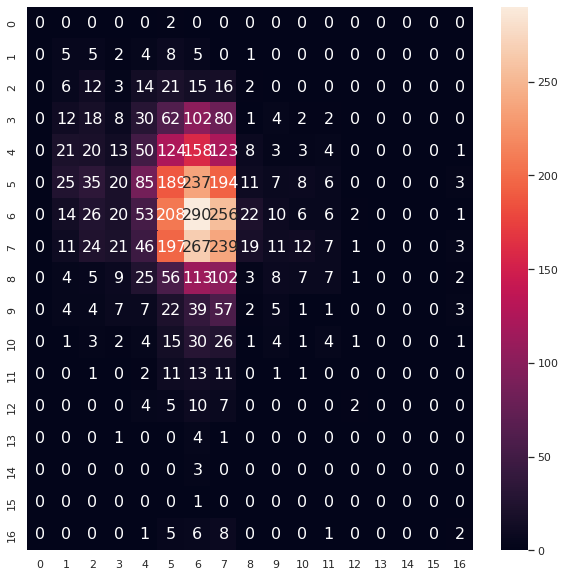

ROC AUC: 0.617773


In [ ]:
# Additional performance metrics
# F1 score = weighted average of percision and recall
f1score = f1_score(y_test, pred, average='weighted')
print("F1 score for meta Model", f1score)

# precision tp / (tp + fp)
precision = precision_score(y_test, pred, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred, average='weighted')
print('Recall: %f' % recall)

matthews_corrcoef_score = matthews_corrcoef(y_test, pred)
print("Matthews Coefficient Score", matthews_corrcoef_score)

matrix = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(matrix, range(17), range(17))
plt.figure(figsize=(10,10))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size
plt.show()

from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, pred_prob, multi_class = 'ovr')
print('ROC AUC: %f' % auc)


## Building Pytorch TabNet Model

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

import torch


# import os
# import wget
# from pathlib import Path
# import shutil
# import gzip

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train.values,
    eval_set=[X_val.values],
    pretraining_ratio=0.8,
)

Device used : cuda
epoch 0  | loss: 38740.05073| val_0_unsup_loss: 3092.06689|  0:00:01s
epoch 1  | loss: 394.26276| val_0_unsup_loss: 26568.29297|  0:00:03s
epoch 2  | loss: 206.86884| val_0_unsup_loss: 191.92473|  0:00:05s
epoch 3  | loss: 174.84653| val_0_unsup_loss: 279.54309|  0:00:06s
epoch 4  | loss: 167.05113| val_0_unsup_loss: 168.34682|  0:00:08s
epoch 5  | loss: 168.94329| val_0_unsup_loss: 152.56433|  0:00:09s
epoch 6  | loss: 170.3052| val_0_unsup_loss: 144.77486|  0:00:11s
epoch 7  | loss: 173.08091| val_0_unsup_loss: 143.1234|  0:00:12s
epoch 8  | loss: 167.15269| val_0_unsup_loss: 142.70009|  0:00:14s
epoch 9  | loss: 166.14287| val_0_unsup_loss: 142.71407|  0:00:15s
epoch 10 | loss: 159.29688| val_0_unsup_loss: 142.81467|  0:00:17s
epoch 11 | loss: 169.81036| val_0_unsup_loss: 142.92554|  0:00:19s
epoch 12 | loss: 169.55091| val_0_unsup_loss: 142.7469|  0:00:20s
epoch 13 | loss: 167.25021| val_0_unsup_loss: 142.90526|  0:00:22s
epoch 14 | loss: 179.70992| val_0_unsup_l

In [ ]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


In [ ]:
max_epochs = 50

In [ ]:
clf.fit(
    X_train=X_train.values, y_train=y_train.values.ravel(),
    eval_set=[(X_train.values, y_train.values.ravel()), (X_val.values, y_val.values.ravel())],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    from_unsupervised=unsupervised_model
    ) 

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: n_a changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: n_d changed from 64 to 8
  warnings.warn(wrn_msg)
/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:96: UserWarning: Pretraining: n_steps changed from 5 to 3
  warnings.warn(wrn_msg)


Loading weights from unsupervised pretraining
epoch 0  | loss: 2.87633 | train_accuracy: 0.06505 | valid_accuracy: 0.06602 |  0:00:00s
epoch 1  | loss: 2.85108 | train_accuracy: 0.064   | valid_accuracy: 0.06259 |  0:00:02s
epoch 2  | loss: 2.83257 | train_accuracy: 0.06883 | valid_accuracy: 0.06973 |  0:00:03s
epoch 3  | loss: 2.81886 | train_accuracy: 0.08268 | valid_accuracy: 0.08059 |  0:00:03s
epoch 4  | loss: 2.80243 | train_accuracy: 0.07369 | valid_accuracy: 0.06945 |  0:00:04s
epoch 5  | loss: 2.78737 | train_accuracy: 0.08227 | valid_accuracy: 0.08488 |  0:00:05s
epoch 6  | loss: 2.77166 | train_accuracy: 0.08081 | valid_accuracy: 0.08202 |  0:00:06s
epoch 7  | loss: 2.75702 | train_accuracy: 0.07938 | valid_accuracy: 0.08031 |  0:00:07s
epoch 8  | loss: 2.74081 | train_accuracy: 0.07826 | valid_accuracy: 0.07774 |  0:00:08s
epoch 9  | loss: 2.72298 | train_accuracy: 0.07722 | valid_accuracy: 0.07574 |  0:00:09s
epoch 10 | loss: 2.70608 | train_accuracy: 0.07957 | valid_accur

In [ ]:
train_df[['Final_IG']].values.ravel()

array([ 4,  8,  9, ..., 17, 17, 17])

In [ ]:
# clf.fit(train_df.drop(['Final_IG'], axis = 1).values, train_df[['Final_IG']].values.ravel())
pred_prob = clf.predict_proba(X_test.values)

log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of meta Model", log_loss_calc)

Test log loss of meta Model 2.542136372082353


In [ ]:
train_df

,ACIDTESTRATIO_Y0,ACIDTESTRATIO_Y1,ACIDTESTRATIO_Y2,ACIDTESTRATIO_Y3,ARTurnover_Y0,ARTurnover_Y1,ARTurnover_Y2,ARTurnover_Y3,ASSETTURNOVER_Y0,ASSETTURNOVER_Y1,...,payableDAYS_Y3,receivabledays_Y0,receivabledays_Y1,receivabledays_Y2,receivabledays_Y3,tangibleNetWorth_Y0,tangibleNetWorth_Y1,tangibleNetWorth_Y2,tangibleNetWorth_Y3,Final_IG
0,2.069111,1.989603,841.794135,1.940195,616054.139871,6.249457e+05,2.999448e+08,-3.174618e+07,601849.879332,577277.798607,...,9.936888e+08,589066.962205,606878.530058,1.055038e+07,-4.463481e+07,613630.915631,579982.194958,3.556085e+06,639556.985467,4
1,1.935439,1.947960,2.099441,2.060341,600307.945570,6.217222e+05,6.237998e+05,6.104738e+05,604157.570546,593796.722887,...,6.004518e+05,610051.003777,627671.479892,6.088758e+05,6.112008e+05,622779.020751,628666.164552,5.899980e+05,606234.413946,8
2,2.089375,2.004466,1.940191,42.845891,617778.264933,6.142079e+05,5.851382e+05,2.317691e+07,623865.574076,578584.361552,...,9.901092e+08,588225.150537,586440.645068,6.265286e+05,5.983958e+05,603373.729906,576695.227666,5.819888e+05,600634.773997,9
3,1.946449,1.929302,502.280308,1.979526,581818.507510,5.901407e+05,-3.076995e+06,-2.287726e+07,597616.076388,569969.274123,...,9.903038e+08,571781.467347,588355.356248,7.708270e+06,-9.581952e+06,572693.371932,625113.542498,6.010550e+05,600634.773997,9
4,2.046373,2.031023,2.089826,1.948107,607548.221988,6.249029e+05,6.215616e+05,6.050586e+05,581364.947825,600378.104251,...,6.126582e+05,596781.113962,626808.604893,5.714849e+05,6.055145e+05,625043.083255,583053.788478,6.267210e+05,630429.182807,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35691,1.790340,1.900946,1.802063,1.750910,609704.341241,6.086371e+05,6.041918e+05,5.831965e+05,587711.659528,608056.269922,...,6.017003e+05,587366.824530,584410.326638,6.065632e+05,5.901975e+05,547091.199888,562245.310003,5.494573e+05,536975.110901,17
35692,1.697055,1.734108,1.758398,1.792799,592472.394951,5.976480e+05,5.921681e+05,6.191299e+05,582982.578522,596554.949206,...,5.858781e+05,614504.318989,574850.424563,6.181821e+05,6.029206e+05,606328.064570,643610.171773,6.572333e+05,638302.716231,17
35693,1.829819,1.551721,1.635218,1.613575,602409.573841,5.836346e+05,5.746952e+05,6.026422e+05,613393.439716,605247.612092,...,6.033650e+05,605482.695594,608247.859229,6.014977e+05,6.009101e+05,757686.094184,762705.494208,7.582519e+05,788244.445173,17
35694,1.907051,1.899883,1.886223,2.015507,601226.867143,6.012050e+05,6.181981e+05,5.962515e+05,588917.184397,613068.520217,...,5.828950e+05,580912.625565,611870.357855,5.884726e+05,5.997331e+05,603907.567649,590549.004601,5.781857e+05,568143.588800,17
